# Identify Fraud from Enron Email Dataset

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data of top Enron executives. The Enron datasets comprising emails and financial data of Enron were made available to the public for research and analysis and can be downloaded from https://www.cs.cmu.edu/~./enron/.

The goal of this project is to use *machine learning* to build a POI (Person of Interest) identifier based on financial and email data made public. Here, 'person of interest' refers to a person who is charged by the law for committing a crime, in this case, the scandal at Enron.  

The overall work done for this project can be divided into four parts, a usual trend in Machine Learning:
   
   1. **Exploring the Enron Dataset:** This involves data cleaning, outlier removal and analyzing.
   
   2. **Feature Processing of the Enron Dataset:** Includes creation, scaling, selection and transforming of features.     
   
   3. **Choosing the Algorithm(s):** Multiple classification models are trained and tuned.
       
   4. **Evaluation:** Involves validation and overall performance check.

**Question 1: Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?**

The goal of the project was to identify Enron employees who may have committed fraud based on the public Enron financial and email dataset while exploring different machine learning algorithms and addressing various feature selection methods. 

The dataset had a total of 146 data points, and 18 of them were POIs in the original dataset. There are 20 features for each person in the dataset, 14 financial features, and 6 e-mail features. These features are analyzed and then fed into classification models. The classification models are then validated and compared to select the optimal classifier.

Outliers were removed with the help of visualization of variables. This has been described in the section titled <a href='#outliers'>'Outlier Investigation & Analyzing the Features'.</a>

In [222]:
import pickle

import numpy as np
import pandas as pd
from time import time

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## I. Exploring the Enron Dataset

- The pickled Enron data is loaded as a `pandas` dataframe for easy anlysis of the dataset.
- The key i.e., the Enron employees name is used as the index of the pandas dataframe.

In [110]:
# Converting the given pickled Enron data to a pandas dataframe.
enron_df = pd.DataFrame.from_records(list(data_dict.values()))

# Set the index of df to be the employees series:
employees = pd.Series(list(data_dict.keys()))
enron_df.set_index(employees, inplace=True)
enron_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [111]:
print ("Size of the enron dataframe: ", enron_df.shape)
print ("Number of data points (people) in the dataset: ", len(enron_df))
print ("Number of Features in the Enron Dataset: ", len(enron_df.columns))

Size of the enron dataframe:  (146, 21)
Number of data points (people) in the dataset:  146
Number of Features in the Enron Dataset:  21


In [112]:
# Counting the number of POIs and non-POIs in the given dataset.
poi_count = enron_df.groupby('poi').size()
print ("Total number of POI's in the given dataset: ", poi_count.iloc[1])
print ("Total number of non-POI's in the given dataset: ", poi_count.iloc[0])

Total number of POI's in the given dataset:  18
Total number of non-POI's in the given dataset:  128


On loading the data as a DataFrame, the data-types are in string/objects.

In [113]:
enron_df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

In [114]:
# Converting the datatypes in the given pandas dataframe 
# into floating points for analysis and replace NaN with zeros.

# Coerce numeric values into floats or ints; also change NaN to zero.
enron_df_new = enron_df.apply(lambda x : pd.to_numeric(x, errors = 'coerce')).copy().fillna(np.nan)
enron_df_new.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,NaN,NaN,NaN,NaN,NaN,94299.0,29.0,38.0,1.0,...,NaN,1740.0,False,585062.0,NaN,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,NaN,-400729.0,NaN,NaN,4890344.0,78552.0,NaN,NaN,NaN,...,NaN,12961.0,False,1788391.0,NaN,170941.0,NaN,NaN,211725.0,6678735.0
CORDES WILLIAM R,NaN,NaN,NaN,NaN,NaN,651850.0,NaN,12.0,10.0,0.0,...,NaN,NaN,False,386335.0,NaN,NaN,58.0,764.0,NaN,1038185.0
HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,NaN,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0


In [115]:
# Dropping column 'email_address' as it is not required in analysis.
enron_df_new.drop('email_address', axis = 1, inplace = True)

# Checking the changed shape of df.
enron_df_new.shape

(146, 20)

### Outlier Investigation & Analyzing the Features <a id='outliers'></a>

The features can be categorized as the following.

**Financial Features (in US dollars):**<br>
``salary
deferral_payments
total_payments
loan_advances
bonus
restricted_stock_deferred
deferred_income
total_stock_value
expenses
exercised_stock_options
other
long_term_incentive
restricted_stock
director_fees``

**Email Features (count of emails):**<br>
``to_messages
email_address
from_poi_to_this_person
from_messages
from_this_person_to_poi
shared_receipt_with_poi``

**POI Labels (boolean):**<br>
``poi``


#### Financial Features: `Bonus` and `Salary`


Drawing scatterplot of **Bonus vs Salary** of Enron employees.

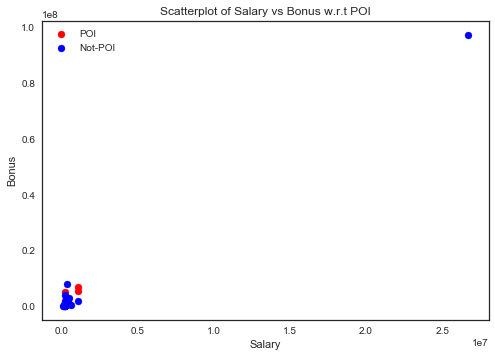

In [116]:
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],
            enron_df_new['bonus'][enron_df_new['poi'] == True], 
            color = 'r', label = 'POI')

plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],
            enron_df_new['bonus'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of Salary vs Bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

It can be noted from the above figure, one non-POI point has very high value of salary and bonus. Checking for the concerned point.

In [117]:
# Finding the non-POI employee having maximum salary
enron_df_new['salary'].argmax()

'TOTAL'

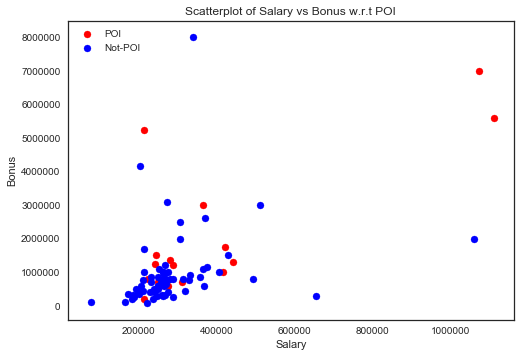

In [118]:
# Deleting the row 'Total' from the dataframe
enron_df_new.drop('TOTAL', axis = 0, inplace = True)

# Drawing scatterplot with the modified dataframe
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],
            enron_df_new['bonus'][enron_df_new['poi'] == True], 
            color = 'r', label = 'POI')

plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],
            enron_df_new['bonus'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of Salary vs Bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

From the above figure, it is observed that the data becomes more spread out and more comprehensible after the outlier removal. Its also observed **that values of bonuses of POIs are higher than that of non-POIs**.

As the POI's were taking larger amounts of money as a bonus, in addition to their high salary, it can be stated that the ratio of bonus to the salary of the POI's will be higher as compared to that of non-POI's. Hence, **a new feature called bonus-to-salary_ratio is created** in the hope that it may aid in the POI identification in the later parts of this project. <a id=#new_features_1></a>

In [119]:
enron_df_new['bonus-to-salary_ratio'] = enron_df_new['bonus']/enron_df_new['salary']

#### Removing Outlier: 'THE TRAVEL AGENCY IN THE PARK.'

From the _enron61702insiderpay.pdf_ provided by findlaw.com, a dataset was observed named 'THE TRAVEL AGENCY IN THE PARK' It is known that Enron had made up some transactions with bogus companies and people [reference](http://www.brighthub.com/office/finance/articles/101200.aspx). So on observing the features of this dataset, it can be considered as an outlier with very low values in all features except in _others_ and _total-payments_. Hence, it is removed. 

In [120]:
# Features of the index 'THE TRAVEL AGENCY IN THE PARK'
enron_df_new.loc['THE TRAVEL AGENCY IN THE PARK']

bonus                           NaN
deferral_payments               NaN
deferred_income                 NaN
director_fees                   NaN
exercised_stock_options         NaN
expenses                        NaN
from_messages                   NaN
from_poi_to_this_person         NaN
from_this_person_to_poi         NaN
loan_advances                   NaN
long_term_incentive             NaN
other                        362096
poi                           False
restricted_stock                NaN
restricted_stock_deferred       NaN
salary                          NaN
shared_receipt_with_poi         NaN
to_messages                     NaN
total_payments               362096
total_stock_value               NaN
bonus-to-salary_ratio           NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [121]:
# Deleting the row with index 'THE TRAVEL AGENCY IN THE PARK'
enron_df_new.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)

#### Financial Features: `deferred_income`, `deferred_payment` and `total_payment`

According to http://www.businessdictionary.com/, 

Deferred payment is "a loan arrangement in which the borrower is allowed to start making payments at some specified time in the future. Deferred payment arrangements are often used in retail settings where a person buys and receives an item with a commitment to begin making payments at a future date."

Deferred income (also known as deferred revenue, unearned revenue, or unearned income) is, in accrual accounting, money received for goods or services which have not yet been delivered. According to the revenue recognition principle, it is recorded as a liability until delivery is made, at which time it is converted into revenue.

As Enron scam involved a lot of undisclosed assets and cheating public by selling assets to shell companies at the end of each month and repurchasing them at the start of next month to hide the accounting losses, there are chances that a lot of deferred revenue by the company was used by the POIs.

In [122]:
enron_df_new['deferred_income'].describe()

count    4.800000e+01
mean    -5.810498e+05
std      9.420764e+05
min     -3.504386e+06
25%     -6.112092e+05
50%     -1.519270e+05
75%     -3.792600e+04
max     -8.330000e+02
Name: deferred_income, dtype: float64

The **deferred_income** feature has mostly negative values as it is the money which has to be returned by the company.

In [123]:
# Finding out the integer index locations of POIs and non-POIs.
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

print("Length of po list: ", len(poi_rs))
print("Length non-poi list: ", len(non_poi_rs))

Length of po list:  18
Length non-poi list:  126


Drawing a scatterplot of **Eemployees with deferred income**

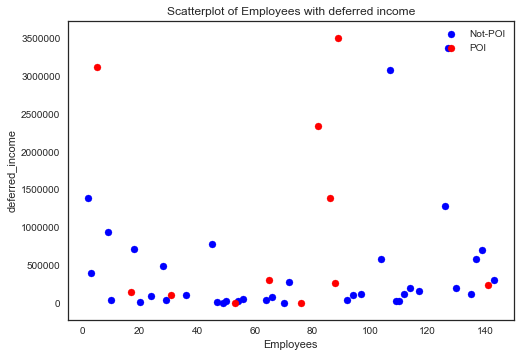

In [124]:
# Since 'deferred_income' is negative, for intuitive understanding,
# a positive person of the variable is created for visualization.
enron_df_new['deferred_income_p'] = enron_df_new['deferred_income'] * -1

plt.scatter(non_poi_rs,
            enron_df_new['deferred_income_p'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['deferred_income_p'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')
    
plt.xlabel('Employees')
plt.ylabel('deferred_income')
plt.title("Scatterplot of Employees with deferred income")
plt.legend(loc='upper right')
plt.show()

The above scatterplot is not much helpful in either detecting outliers or finding patterns as some POIs as well as non-POIs have high values of deferred income. Although, a very trend does suggest POIs to have higher deferred income.


Creating a scatterplot of **`total_payments` vs `deferral_payments` w.r.t `POI`**.

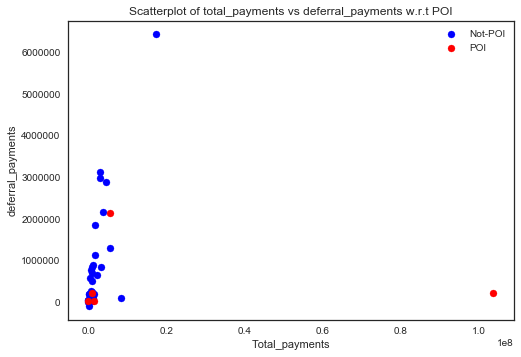

In [125]:
# Scatterplot of total_payments vs deferral_payments w.r.t POI
plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == False],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == True],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

plt.xlabel('Total_payments')
plt.ylabel('deferral_payments')
plt.title("Scatterplot of total_payments vs deferral_payments w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above scatterplot, it can be observed that the **majority of POIs have a meager value of deferral payments as compared to the deferral_payments of non-POIs**. We can also observe there are two outliers. The one having a high value of total_payments is a POI, and the other outlier with a high value of deferral payments is a non-POI. Hence, **removing the non-POI outlier.**

In [126]:
# Finding the non-POI employee having maximum 'deferral_payments'
enron_df_new['deferral_payments'].argmax()

'FREVERT MARK A'

In [127]:
# Removing the non-POI employee having maximum 'deferral_payments'
enron_df_new.drop('FREVERT MARK A', axis = 0, inplace = True)

#### Financial Features : `long_term_incentive`

Making a scatterplot to check the `long_term_incentive` of different Enron employees.

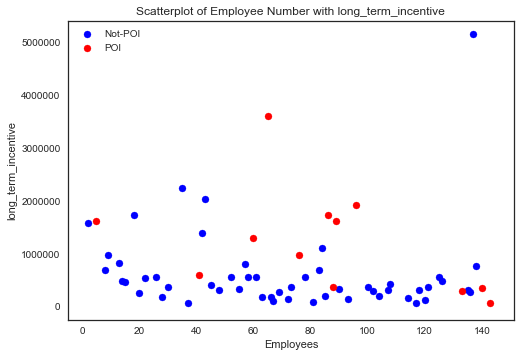

In [128]:
# Finding out the integer index locations of POIs and non-POIs
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

# Making a scatterplot
plt.scatter(non_poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

plt.xlabel('Employees')
plt.ylabel('long_term_incentive')
plt.title("Scatterplot of Employee Number with long_term_incentive")
plt.legend(loc='upper left')
plt.show()

One employee has a very high value of `long_term_incentive`, so considering this point as an outlier and removing it.  

In [129]:
enron_df_new['long_term_incentive'].argmax()

'MARTIN AMANDA K'

In [130]:
enron_df_new.drop('MARTIN AMANDA K', axis = 0, inplace = True)

#### Financial Features : `restricted_stock` and `restricted_stock_deferred`

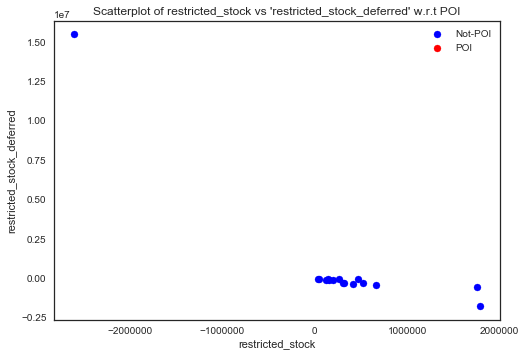

In [131]:
# Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == False],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == True],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('restricted_stock')
plt.ylabel('restricted_stock_deferred')
plt.title("Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

In [132]:
enron_df_new['restricted_stock_deferred'].argmax()

'BHATNAGAR SANJAY'

There is an obtained **outlier in the feature `restricted_stock_deferred`**. Taking a quick look at the values of `restricted_stock_deferred` _most of the values are zeros_, and the remaining few are negative values. The outlier found here is the Enron employee _'BHATNAGAR SANJAY'_ who is not a POI. Hence, this **datapoint is removed.** There is no exciting observation in the other axis of this graph.  

In [133]:
enron_df_new.drop('BHATNAGAR SANJAY', axis = 0, inplace = True)

#### Email Features : ` from_poi_to_this_person` and `from_this_person_to_poi`

Given that the dataset is related to the emails, it can be thought that for doing such a big scam, the POI's might frequently have communication between them via E-mails. Hence, by checking on the number of e-mails transferred between POIs and an Employee, we can guess for the involvement of that person in that scam.

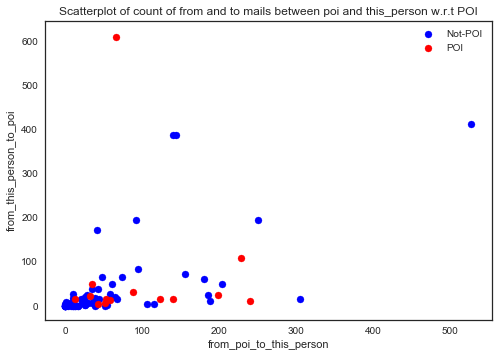

In [134]:
plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == False],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == True],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('from_poi_to_this_person')
plt.ylabel('from_this_person_to_poi')
plt.title("Scatterplot of count of from and to mails between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

This scatterplot shows the relationship between the count of emails sent to and fro among different employees of Enron. I think a different feature showing the proportion of mail sent by employees and POI to each other will be more helpful in finding the POI. As POIs are more likely to have more communications with other POIs as compared to communication with other non-POIS, **two new features are created.**

#### Features created: `fraction_mail_from_poi` and `fraction_mail_to_poi` <a id=#new_features_2></a>

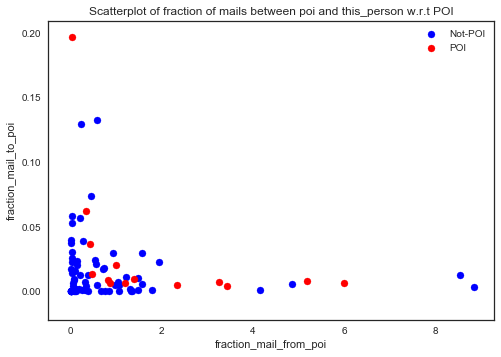

In [136]:
enron_df_new['fraction_mail_from_poi'] = enron_df_new['from_poi_to_this_person']/enron_df_new['from_messages'] 
enron_df_new['fraction_mail_to_poi'] = enron_df_new['from_this_person_to_poi']/enron_df_new['to_messages']

# Scatterplot of fraction of mails from and to between poi and this_person w.r.t POI
plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == False],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == True],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('fraction_mail_from_poi')
plt.ylabel('fraction_mail_to_poi')
plt.title("Scatterplot of fraction of mails between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above figure, the difference between POs and non-POI points can be clearly classified. The red dots representing **POIs are more distinct, have higher values and are more separate from the non-POI blue points**.

## II. Feature Processing

**Question 2: What features did you end up using your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your feature that does not come ready-made in the dataset – explain what feature you tried to make, and the rationale behind it.**

- A pipeline was created, and we decided to try `SelectKBest` in a range of 8 to 11 features and use it on 5 different algorithms. Most of the algorithms required 9 features as determined by `GridSearchCV`. <br><br>

- Feature Preprocessing (including feature scaling) was done in <a id="feature_p">this section</a>.<br><br>

- Additional features were created during the exploratory data analysis i.e. <a id="new_features_2">'fraction_mail_from_poi', 'fraction_mail_to_poi'</a> & <a id="new_features_1">'bonus-to-salary_ratio'</a>.<br><br>

- The features selected for the classifier using `SelectKBest` described in <a id="#feature_sel">this</a> section. 

### Preparing for Feature Processing

In [138]:
# Clean all 'inf' values which we got if the person's from_messages = 0
enron_df_new = enron_df_new.replace('inf', 0)
enron_df_new = enron_df_new.fillna(0)

# Converting the above modified dataframe to a dictionary
enron_dict = enron_df_new.to_dict('index')
print("Features of modified data_dictionary:-")
print("Total number of datapoints: ",len(enron_dict))
print("Total number of features: ",len(enron_dict['METTS MARK']))

Features of modified data_dictionary:-
Total number of datapoints:  141
Total number of features:  24


In [139]:
# Store to my_dataset for easy export below.
dataset = enron_dict

#### Features Choose to be Used in the POI identifier

Out of the all features available, (given and created above), the following 24 features would be used. The given features can be divided into two types: financial features and email features.  

  - **17 Financial Features:** 
  `['salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'expenses','restricted_stock_deferred', 'restricted_stock', 'deferred_income','total_payments','other','shared_receipt_with_poi', 'loan_advances', 'director_fees', 'exercised_stock_options', 'deferral_payments', 'total_stock_value', 'restricted_stock']`<br><br>
                
  - **6 Email Features:** `['fraction_mail_from_poi', 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'from_messages']`<br><br>
  
  - **POI:** Which is the target variable.

In [158]:
# Features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi" (target variable).

features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'deferral_payments', 'expenses', 
                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income','fraction_mail_from_poi', 'total_payments',
                 'other', 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 
                 'from_messages', 'shared_receipt_with_poi', 'loan_advances', 'director_fees', 'exercised_stock_options',
                'total_stock_value']

In [159]:
# Extract features and labels from dataset for local testing
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Outline of Steps for Feature Scaling
 
**1. Feature Scaling:** `MinMaxScaler` is used which scales features to lie between zero and one. MinMaxScaler transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e., between zero and one. It is also limited to be used with algorithms that involve distance measures to avoid loss of information.

**2. Feature Selection**: Feature selection/dimensionality reduction on sample sets is essential to improve estimators’ accuracy scores, boost performance & simplification of the model. In this project, `SelectKBest` to find the 'K' best or high-scoring features. Objects of these functions, take as input a scoring function that returns univariate scores and p-values. Here, `f_classif` is used as the scoring function which computes the ANOVA F-value between labels and features for classification tasks.  

**3. Pipeline:** Sequentially apply feature processing steps such as scaling, selection, and classification. Sklearn's `GridSearchCV` module automates this process by performing a grid search over a range of parameter values for an estimator.

**4. Principle Component Analysis (PCA):** PCA was tried, but it did not improve f1, precision or recall for the selected classification algorithms. Hence, it was not used and has not been described below to keep the notebook to-the-point. 

In [210]:
# Split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, \
labels_train, labels_test = cross_validation.train_test_split(features, labels, 
                                                              test_size=0.3, random_state=42)

# Stratified ShuffleSplit cross-validator
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.3, random_state = 42)

# Importing modules for feature scaling and selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Defining features to be used via the pipeline
## 1. Feature scaling
scaler = MinMaxScaler()

## 2. Feature Selection
skb = SelectKBest(f_classif)

## III. Choosing the Algorithm

For this project, the following algorithms were selected.

1. Logistic Regression
2. KNN (K-Nearest Neighbour)
3. Gaussian Naive Bayes Classifier

In [220]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

### Logistic Regression

In [212]:
# Classifier 1: Logistic Regression
lr_clf = LogisticRegression()

pipeline = Pipeline(steps=[("SKB", skb), ("LogisticRegression", lr_clf)])

param_grid = {"SKB__k": range(9, 10),
              'LogisticRegression__tol': [1e-2, 1e-3, 1e-4],
              'LogisticRegression__penalty': ['l1', 'l2']
             }

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
# clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)
print("Training Time: ", round(time()-t0, 3), "s")

# Best algorithm
clf = grid.best_estimator_

t0 = time()
# Refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print("Testing time: ", round(time()-t0, 3), "s")

# Evaluation Measures
print("Accuracy of DT classifer is  : ", accuracy_score(labels_test, prediction))
print("Precision of DT classifer is : ", precision_score(prediction, labels_test))
print("Recall of DT classifer is    : ", recall_score(prediction, labels_test))
print("f1-score of DT classifer is  : ", f1_score(prediction, labels_test))

Training Time:  8.796 s
Testing time:  0.002 s
Accuracy of DT classifer is  :  0.809523809524
Precision of DT classifer is :  0.333333333333
Recall of DT classifer is    :  0.333333333333
f1-score of DT classifer is  :  0.333333333333


### KNN Classifier

In [216]:
# Classifier 2: KNN Classifier

clf_knn = KNeighborsClassifier()

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state = 42)
pipeline = Pipeline(steps = [("scaling", scaler), ("SKB", skb),  ("knn",clf_knn)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18], 
              "knn__n_neighbors": [3,4,5,6,7,8,9,11,12,13,15],
              }

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
# clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)
print("Training time: ", round(time()-t0, 3), "s")

# Best Algorithm
clf = grid.best_estimator_

t0 = time()
# Refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print("Testing time: ", round(time()-t0, 3), "s")

# Evaluation measures
print("Accuracy of DT classifer is  : ", accuracy_score(labels_test, prediction))
print("Precision of DT classifer is : ", precision_score(prediction, labels_test))
print("Recall of DT classifer is    : ", recall_score(prediction, labels_test))
print("f1-score of DT classifer is  : ", f1_score(prediction, labels_test))

Training time:  9.281 s
Testing time:  0.002 s
Accuracy of DT classifer is  :  0.880952380952
Precision of DT classifer is :  0.333333333333
Recall of DT classifer is    :  0.666666666667
f1-score of DT classifer is  :  0.444444444444


### Gaussian Naive Bayes

In [217]:
## Classifier 3: Gaussian Naive Bayes (GaussianNB) classifier

clf_gnb = GaussianNB()

pipeline = Pipeline(steps = [("SKB", skb), ("NaiveBayes", clf_gnb)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
grid.fit(features, labels)
print("Training time: ", round(time()-t0, 3), "s")

# Best Algorithm
clf = grid.best_estimator_

t0 = time()
# Refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print("Testing time: ", round(time()-t0, 3), "s")

print("Accuracy of GaussianNB classifer is  : ", accuracy_score(labels_test, prediction))
print("Precision of GaussianNB classifer is : ", precision_score(prediction, labels_test))
print("Recall of GaussianNB classifer is    : ", recall_score(prediction, labels_test))
print("f1-score of GaussianNB classifer is  : ", f1_score(prediction, labels_test))

Training time:  0.666 s
Testing time:  0.003 s
Accuracy of GaussianNB classifer is  :  0.833333333333
Precision of GaussianNB classifer is :  0.5
Recall of GaussianNB classifer is    :  0.428571428571
f1-score of GaussianNB classifer is  :  0.461538461538


**Question 3: What algorithm did you end up using? What other one(s) did you try? How did
model performance differ between algorithms?**

In total, three algorithms were tried viz. Gaussian Naïve Bayes, Logistic Regression, KNN (K-Nearest Neighbors). *Gaussian Naïve Bayes was the best performing model amongst all the models* based on the f1-score and the minimum requirement of 0.33 for precision and recall. KNN also comes close, but I chose Gaussian NB because of its precision.

**Question 4: What does it mean to tune the parameters of an algorithm, and what can happen if you do not do this well? How did you tune the parameters of your particular algorithm?**

The process of tuning the parameters involves setting the values of the algorithmic parameters to such optimal values that enable us to complete a machine learning task in the "best possible way." 

Not correctly tuning will result in the sub-optimum or poor performance of the algorithm while making the whole machine learning task very time-consuming. Also, algorithms are not explicitly tuned to any dataset. Therefore, iteratively tuning our algorithm to obtain an evaluation we are satisfied with is recommended. 

This project utilized three algorithms and used the `GridSearchCV` function to obtain the best parameters for them. Since there are no parameters to tune for Gaussian Naïve Bayes, they have not been specified. However, for completeness, the tuning parameters for KNN have been mentioned below.

```python
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18], 
              "knn__n_neighbors": [3,4,5,6,7,8,9,11,12,13,15],
              }
              
grid = GridSearchCV(pipeline, param_grid, ... scoring = 'f1')
```

### Finding out the Features Selected by `SelectKBest` for GaussianNB <a id="#feature_sel"></a>

In [221]:
# Obtaining the boolean list showing selected features
features_selected_bool = grid.best_estimator_.named_steps['SKB'].get_support()

# Finding the features selected by SelectKBest
features_selected_list = [x for x, y in zip(features_list[1:], features_selected_bool) if y]
print("Total number of features selected by SelectKBest algorithm: ", len(features_selected_list))

# Finding the score of features 
feature_scores =  grid.best_estimator_.named_steps['SKB'].scores_

# Finding the score of features selected by selectKBest
feature_selected_scores = feature_scores[features_selected_bool]

# Creating a pandas dataframe and arranging the features based on their scores and ranking them 
imp_features_df = pd.DataFrame({'Features_Selected':features_selected_list, 'Features_score':feature_selected_scores})
imp_features_df.sort_values('Features_score', ascending = False, inplace = True)
Rank = pd.Series(list(range(1, len(features_selected_list)+1)))
imp_features_df.set_index(Rank, inplace = True)

print("The following table shows the feature selected along with its corresponding scores.")
imp_features_df

Total number of features selected by SelectKBest algorithm:  12
The following table shows the feature selected along with its corresponding scores.


,Features_Selected,Features_score
1,deferred_income,13.287587
2,bonus,12.438591
3,salary,12.225775
4,exercised_stock_options,11.166453
5,fraction_mail_from_poi,10.598733
6,total_stock_value,10.191784
7,long_term_incentive,10.164526
8,bonus-to-salary_ratio,9.869367
9,total_payments,9.361047
10,other,9.141458


## IV. Evaluation

**Question 5: What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?**

Validation is usually performed to ensure that the machine learning algorithm we have selected, generalizes well. A classic mistake is over-fitting, where our model performs very well on the training dataset but significantly worse on the cross-validation and testing datasets. 

To overcome this mistake, we can perform cross0validation on the dataset. Although we can use the train_test_split, cross-validation technique, a better fit for our project would be to use the `StratifiedShuffleSplit` technique.

- `StratifiedShuffleSplit` is used when there are few observations in a dataset being used for analysis. This technique randomly shuffles through our data, creating testing and training data.  The stratified shuffle split is also used to handle class imbalances in the data. This is important, especially since there are very few POIs in the data.<br><br>

- `StratifiedShuffleSplit` creates train/validation subsets (as per the code above, it will create 100 of them). Internally, `GridSearchCV` estimates the models using the 100 train subsets and validate the model on the 100 validation subsets.

#### Evaluation Metrics
In this project, while training, it was kept in mind to optimize the precision and recall. Hence, I used f1-score as the key measure for algorithms' performance as f1_score considers both the precision and the recall.

The metrics have been summarized below as they are later used to draw inferences from the study.

- **Accuracy** is the ratio of correctly predicted observation to the total observations.<br><br>
$Accuracy = \frac{TP + TN}{TP+FP+FN+TN}$<br><br>

- **Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations.<br><br>
$Precision = (\frac{TP}{TP + FP})$<br><br>

- **Recall** is the ratio of correctly predicted positive observations to the all observations in actual class.<br><br>
$Recall = (\frac{TP}{TP + FN})$<br><br>

- **F1-score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.<br><br>
$f1 = 2.(\frac{precision.recall}{precision + recall})$<br><br>

**Question 6: Give at least 2 evaluation metrics and your average performance for each of them. Explain an interpretation of your metrics that says something human-understandable about your  algorithm’s performance.**

Metric values obtained after running the **`tester.py`** file : 

| Algorithm used       | Accuracy | Precision | Recall | f1 score |
|----------------------|----------|-----------|--------|----------|
| Gaussian Naive Bayes | 0.852    | 0.480     | 0.387  | 0.428    |

##### The following can be noted from the obtained values.

- **Accuracy can be interpreted as ** 85.2% predictions on the entire test set have been made correctly. 

Accuracy, although a crucial metric can be misleading, mainly when dealing with imbalanced classes, or in other words, when the data is skewed towards one class. This is the case with the Enron set — since there are much more non-POIs than POI (you can just guess the more common class label for every point, which is not a very insightful strategy but still get decent Accuracy).

- **Precision can be interpreted as **  if a person is being classified as a POI by the classifier, there is a 48.0% chance that the person is a POI.  

Precision implies  that whenever a POI gets flagged in the test set, there's a lot of confidence that it’s very likely to be a real POI and not a false alarm.On the other hand, the tradeoff is that sometimes real POIs are missed, since the classifier is effectively reluctant to pull the trigger on edge cases.

- **Recall can be interpreted as:** of all the actual POIs considered, 38.7% of all the POIs can be classified correctly as a POI by the classifier. 

38.7% might seem low, but this metric is particularly insightful for the Enron case. Since we are dealing with a criminal situation, we want our classifier to err on the side of guessing guilty – higher levels of scrutiny — so it makes sure as many people get flagged as POI, maybe at a cost of identifying some innocent people along the way. Boosting its Recall metric the classifier ensures that is correctly identifying every single POI. The tradeoff is that the algorithm will be biased towards "overdoing" it.